# Object Detection using GluonCV on Amazon SageMaker

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation and Exploration](#[Optional]-Data-Preparation-and-Exploration)
4. [Experimentation and Prototyping](#Experimentation-and-Prototyping)
5. [Train the model](#Train-the-model)
6. [Host the model](#Host-the-model)
7. [Test the model](#Test-the-model)
8. [Clean up](#Clean-up)

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes an image as input and provides a bounding box on the image where an object of interest is found.  It also identifies what type of object the box encapsulates.  To create such a solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that it can learn about the dataset. Finally, we can then host the trained model in an endpoint, to which we can supply images.

This notebook is an end-to-end example showing how GluonCV's Object Detection algorithms can be used with Amazon SageMaker, and a public dataset of bird images. We demonstrate how to train and to host an object detection model based on the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset.  GluonCV provides variants of SSD, YOLOv3 and Faster RCNN algorithms for object detection algorithm. In this notebook we demonstrate YOLOv3 on mobilenet1.0 with weights pretrained on the [VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset.

![Sample results detecting a pair of goldfinch on a feeder](./goldfinch_detections.png)


## Setup

Before preparing the data, there are some initial steps required for setup.

First, you should be running this notebook on a **ml.c5d.4xlarge** or larger instance if you plan to run the training script locally on your notebook. Otherwise, you'll need to lower the batch size to avoid out-of-memory errors.

Any GPU instances like the ml.p3.2xlarge will do, and in practice, will be the ideal choice for a notebook instance.

Run the following cell to import the depedencies on this notebook. Most of the libraries that you need for MXNet and Gluon development are already packaged into the conda_mxnet_p36 environment.

In [2]:
import os
import boto3
import time
from datetime import datetime
import numpy as np
import pandas as pd
import mxnet as mx
from mxnet import autograd, gluon
from matplotlib import pyplot as plt
import sagemaker
from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

role = sagemaker.get_execution_role()

GluonCV isn't pre-installed into this environment. However, most of the dependencies required by GluonCV have already been packaged into the **conda_mxnet_p36** environment. 

GluonCV has the following requirements that we will have to install manually:
* MXNet 1.4
* GluonCV libraries

Installation instructions for GluonCV are provided [here](https://gluon-cv.mxnet.io/#installation)

In [3]:
# MXNet has different libraries for GPU versus CPU environments. 
# We need to detect whether GPU is available on this instance.
USE_GPU = True
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
    print('GPU device is available')
except:
    ctx = [mx.cpu()]
    USE_GPU = False
    print('Using CPU on local machine. GPU device was not detected')

Using CPU on local machine. GPU device was not detected


Next we..
* Ensure pip is up to date.
* Upgrade MXNet 1.3 to 1.4 with the appropriate libraries depending on whether GPU is available.
* Install GluonCV

In [4]:
start = time.time()
os.system('pip install --upgrade pip')

if USE_GPU :
    os.system('pip install mxnet-cu90mkl>=1.4.0 --upgrade')
else :
    os.system('pip install mxnet-mkl>=1.4.0 --upgrade')

os.system('pip install gluoncv --upgrade')

end = time.time()

print("GluonCV dependencies were installed in {:3f} seconds.".format(end-start))

GluonCV dependencies were installed in 3.907255 seconds.


Gluoncv should now be available for us. Import our required libraries.

In [5]:
import gluoncv as gcv
from gluoncv.utils import download, viz

In the next session, we'll create an optimized dataset (RecordIO format) for training our YOLOv3 model. The process can take 15 minutes. 

It's up to you whether you like to go through the steps of pre-processing your dataset into RecordIO format. Alternatively, I've provided pre-processed datasets for you to use.

Run the cell below to set the locations of the pre-processed train and validation datasets. Note that MXNet doesn't require RecordIO format, but there are various benefits as described below.

In [6]:
SAMPLE_TRAINING_DATASET = 's3://reinvent2018-sagemaker-pytorch/datasets/caltech-birds/recordio/train'
SAMPLE_TEST_DATASET = 's3://reinvent2018-sagemaker-pytorch/datasets/caltech-birds/recordio/test'

# [Optional] Data Preparation and Exploration

---
This section is **optional**. For the purpose of making this lab as efficient as possible, data sets have already been prepared for you in MXNet [RecordIO format](https://mxnet.incubator.apache.org/versions/master/faq/recordio.html), which has various [benefits](https://mxnet.incubator.apache.org/versions/master/faq/recordio.html) including performance enhancements. The following are steps that were taken to produce training and validation samples in RecordIO format. Take note of the utility functions that MXNet provides for format conversion as well as the native data loaders. These are great features that reduce data wrangling work, and aren't provided by most frameworks.

---
This [link](https://cv-workshop-2.notebook.us-west-2.sagemaker.aws/notebooks/aws-cv-jumpstarter/notebooks/lab3b-optional-generate-recordio-files.ipynb) will launch another notebook, which will guide you through this optional section.

# Experimentation and Prototyping

The notebook environment is an ideal environment for rapid prototyping and experimentation. Run the cell below to preview the YOLOv3 training script that we will use to train the model.

The script is no different than one you would run outside of the Amazon SageMaker environment. The only exception is that are conditions in the script to set parameters to environment variables that will be present when we run remote SageMaker training. They're only necessary if you plan to refactor your script to take advantage of the zero-setup SageMaker training capabilities.

In [9]:
!pygmentize ../scripts/gluoncv_yolo3-train.py

import argparse
import os
#from os import walk
#import shutil
import logging
import time
#import json
import warnings
import numpy as np
import mxnet as mx
import pandas as pd
from mxnet import nd
from mxnet import gluon
from mxnet import autograd
import gluoncv as gcv
from gluoncv import data as gdata
from gluoncv import utils as gutils
from gluoncv.model_zoo import get_model
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultValTransform
from gluoncv.data.dataloader import RandomTransformDataLoader
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from gluoncv.utils.metrics.coco_detection import COCODetectionMetric
from gluoncv.utils import LRScheduler, LRSequential

EVAL_METRICS = {
    'mAP':0.0,
    'ObjLoss':10000.0,
    'BoxCenterLoss':10000.0,
    'BoxScaleLoss':10000.0,
    'ClassLoss':10000.0
}

MODEL_DIR = ""
CLASSES_FILE = ""

The command below runs the above script on this notebook. The script is only configure to run for one epoch because it can take over 5 minutes to run a single epoch on CPU.

The YOLOv3 script has been configured to use mobilenet1.0 (versus darknet), and will be initialized with weights pretrained on the VOC dataset.

It's **optional** to run this script locally.

In [8]:
!mkdir ./models
!python ../scripts/gluoncv_yolo3-train.py \
--model-dir ./models \
--train ../data/caltech_birds_sample/recordio/train \
--test ../data/caltech_birds_sample/recordio/test \
--lr 0.001 \
--opt adam \
--local True \
--pre-trained-weights VOC \
--network mobilenet1.0 --syncbn True --batch-size 16 --epochs 1

mkdir: cannot create directory ‘./models’: File exists
[20:04:27] src/imperative/./imperative_utils.h:90: GPU support is disabled. Compile MXNet with USE_CUDA=1 to enable GPU support.
[20:04:28] src/operator/nn/mkldnn/mkldnn_base.cc:74: Allocate 8192 bytes with malloc directly
[20:04:28] src/operator/nn/mkldnn/mkldnn_base.cc:74: Allocate 32768 bytes with malloc directly
[20:04:28] src/operator/nn/mkldnn/mkldnn_base.cc:74: Allocate 18874368 bytes with malloc directly
INFO:root:Namespace(batch_size=16, data_prefix='', data_shape=416, epochs=1, gpus='0', label_smooth=False, local=True, log_interval=100, lr=0.001, lr_decay=0.1, lr_decay_epoch='160,180', lr_decay_period=0, lr_mode='step', mixup=False, model_dir='./models', momentum=0.9, network='mobilenet1.0', no_mixup_epochs=20, no_random_shape=False, no_wd=False, num_samples=150, num_workers=4, obj_metric='mAP', opt='adam', pre_trained_weights='VOC', resume='', save_interval=50, save_prefix='yolo3_mobilenet1.0_custom', seed=233, start_epo

## Validate your Scripts

You may eventually need to perform large-scale training that is beyond what want can be done from your local notebook. Before you leverage SageMaker traiing capabilities, you can run your training script in **"local mode"** to validate that your script will run within the SageMaker training environment.

Local mode will deploy a SageMaker training container locally, and run your script. In the following steps we will setup our notebook to train in "local mode."

### Installing Dependencies on SageMaker Managed Containers

---

One of the main benefits of leveraging the "Bring-Your-Own-Script" (BYOS) integration strategy is that it reduces alot of heavy-lifting compared to the alternative. For instance, if you want to integrate a custom algorithm in R with Amazon SageMaker, it is feasible. However, at this point in time, the BYOS integration option doesn't supported in R. Integrating your R algorithm would require you to build  an Amazon SageMaker compatible container to house your custom [algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html).

MXNet, however, supports BYOS--Amazon SageMaker provides and maintains MXNet containers natively. The one catch is that Amazon SageMaker currently supports containers for MXNet 1.3 and lower. GluonCV requires MXNet 1.4. 

However, we can still avoid having to build our own containers by leveraging the MXNet 1.3 SageMaker container. This involves providing a requirements.txt file along with your deployment to instruct Amazon SageMaker on how to update the MXNet1.3 container on launch.

Since the dependencies are dependent on GPU availability, I've provided two variations of requirements.txt for our GluonCV YOLOv3 algorithm.

---
Run the cell below to preview the dependency updates required by GluonCV for GPU enabled training instances.

In [10]:
!pygmentize ../scripts/requirements-gpu.txt

pandas
mxnet-cu90mkl>=1.4.0
gluoncv


Run the cell below to preview the dependency updates required by GluonCV when your training instance doesn't have GPU available.

In [11]:
!pygmentize ../scripts/requirements-cpu.txt

pandas
mxnet-mkl>=1.4.0
gluoncv


The appropriate requirements.txt file has to be provided depending on which training instance you've selected. The requirements.txt needs to be place in the root directory of your scripts. In the following steps, we'll provide some utilities to take care of this.

### GPU Enabled Environment Considerations

---
Your environment and certain hyperparameters are dependent on the amount of available GPU. We need to ensure the right libraries are installed if you select a GPU enabled instance. 

Secondly, if you have multiple GPUs either on a single instance or distributed cluster, you have more GPU memory available to support larger batch sizes for accelerating training time. Larger batch sizes will help accelerate and scale your training process.

This YOLOv3 script also needs to know how many devices you like to use for multiple GPU training on a single instance, so that data sharding can be done in the script to facilitate data parallelism scaling.

Note that you may need to adapt to model performance degradation as a result of training on large batch sizes by lowering the learning rate.

In [16]:
import shutil

# sample selection of SageMaker instances and available GPUs
INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.p3.8xlarge':4,
    'ml.c5.4xlarge':0,
    'ml.c5.xlarge':0
}

def set_requirements_text(gpu_train=True) :
    
    if gpu_train :
        shutil.copy('../scripts/requirements-gpu.txt','../scripts/requirements.txt')
    else :
        shutil.copy('../scripts/requirements-cpu.txt','../scripts/requirements.txt')

    !pygmentize ../scripts/requirements.txt

def environment_device_config(instance_selection, use_ei=False) :
    
    GPU_TRAIN = (INSTANCE_GPUS[instance_selection] > 0) or use_ei

    gpu_devices = '0'
    for i in range(1,INSTANCE_GPUS[instance_selection]) :
        gpu_devices+= ","+str(i)

    print('Set requirements.txt for {}:'.format('GPU' if GPU_TRAIN else 'CPU')) 
    print('-----------------------------------')
    set_requirements_text(GPU_TRAIN)
    print('-----------------------------------')
    
    config={
        "gpu_devices":gpu_devices,
        "batch_size_range": [13*INSTANCE_GPUS[instance_selection] if GPU_TRAIN else 16,
                          16*INSTANCE_GPUS[instance_selection] if GPU_TRAIN else 32]
    }
    
    print('You have selected {}{}, which will utilize {}.'.format(instance_selection, 
                                                                   ' with EI' if use_ei else '',
                                                                   'GPU' if GPU_TRAIN else 'CPU'))
    print('Recommended GPU dependent configurations: {}'.format(config))
    
    return config
      
config = environment_device_config('ml.c5.4xlarge')

Set requirements.txt for CPU:
-----------------------------------
pandas
mxnet-mkl>=1.4.0
gluoncv
-----------------------------------
You have selected ml.c5.4xlarge, which will utilize CPU.
Recommended GPU dependent configurations: {'gpu_devices': '0', 'batch_size_range': [16, 32]}


---

### Amazon SageMaker Local

We're now ready to configure our script with appropriate hyperparameters, and launch Amazon SageMaker training in local mode. 

We'll use the following hyperparameters.

In [14]:
params = {
    'optimizer': 'adam',
    'lr': 0.0001,
    'epochs': 1,
    'batch-size': config['batch_size_range'][1],
    'network':'mobilenet1.0',
    'syncbn':True,
    'pre-trained-weights':"VOC"} 
print(params)

{'optimizer': 'adam', 'lr': 0.0001, 'epochs': 1, 'batch-size': 32, 'network': 'mobilenet1.0', 'syncbn': True, 'pre-trained-weights': 'VOC'}


A sample dataset of the Caltech Birds dataset in RecordIO format should have been copied over to your notebook through the Github integration. Run the cell to validate the contents.

In [27]:
from os import listdir

LOCAL_TRAIN_DATA_DIR = os.path.join(os.getcwd(),'../data/caltech_birds_sample/recordio/train')
LOCAL_TEST_DATA_DIR = os.path.join(os.getcwd(),'../data/caltech_birds_sample/recordio/test')

print('Local training data directory contents:')
print('---------------------------------------')
for f in listdir(LOCAL_TRAIN_DATA_DIR) :
    print(f)
print()
print('Local test data directory contents:')
print('---------------------------------------')
for f in listdir(LOCAL_TEST_DATA_DIR) :
    print(f)

Local training data directory contents:
---------------------------------------
classes.csv
train.idx
train.rec

Local test data directory contents:
---------------------------------------
val.rec
val.idx


Next, we instantiate an MXNet estimator. This object ecapsulates your MXNet algorithm including infrastructure configurations that it will leverage when you execute training via the fit() method.

The parameter **train_instance_type = 'local'** informs SageMaker that you wish to run this estimator in local mode. Secondly, ensure you replace /'<<NAME YOUR TRAINING JOB/>>' with a unique name.

In [32]:
#BASE_JOB_NAME ='dylantong-yolo3-local-training'
BASE_JOB_NAME='<<NAME YOUR TRAINING JOB>>'
SOURCE_DIR = '../scripts'

local_estimator = MXNet(entry_point='gluoncv_yolo3-train.py',
                       role=role,
                       source_dir=SOURCE_DIR,
                       framework_version='1.3.0',
                       py_version='py3',
                       train_instance_count=1,
                       train_instance_type='local',
                       base_job_name=BASE_JOB_NAME,
                       hyperparameters=params)

Calling fit() will deploy a training container locally to run your training script. In local mode, you have the option of utilizing data from a local file system as shown below. Alternatively, you can specify S3 locations as would normally do for remote training (commented out below).

**The script currently hangs during SageMaker local training. I'm currently working on this issue. Please skip this cell for now.**

In [33]:
local_estimator.fit({'train': 'file://'+LOCAL_TRAIN_DATA_DIR, 
                    'test': 'file://'+LOCAL_TEST_DATA_DIR})

#local_estimator.fit({'train': SAMPLE_TRAINING_DATASET, 
#                    'test': SAMPLE_TEST_DATASET})

Creating tmp2strvr80_algo-1-nuvcl_1 ... 
Attaching to tmp2strvr80_algo-1-nuvcl_12mdone
algo-1-nuvcl_1  | 2019-05-16 21:12:01,357 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
algo-1-nuvcl_1  | 2019-05-16 21:12:01,360 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-nuvcl_1  | 2019-05-16 21:12:01,372 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_MODULE_DIR': 's3://sagemaker-us-west-2-803235869972/dylantong-yolo3-local-training-2019-05-16-21-11-10-597/source/sourcedir.tar.gz', 'SM_INPUT_CONFIG_DIR': '/opt/ml/input/config', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_HP_NETWORK': 'mobilenet1.0', 'SM_CHANNEL_TEST': '/opt/ml/input/data/test', 'SM_HP_EPOCHS': '1', 'SM_OUTPUT_DIR': '/opt/ml/output', 'SM_USER_ENTRY_POINT': 'gluoncv_yolo3-train.py', 'SM_NUM_GPUS': '0', 'SM_USER_ARGS': '["--batch-size","32","--epochs","1","--lr","0.0001","--network","mobilenet1.0","--optimizer","adam","--

algo-1-nuvcl_1  |   Downloading https://files.pythonhosted.org/packages/ee/18/4cd2e84c6aff0c6a50479118083d20b9e676e5175a913c0ea76d700fc244/kiwisolver-1.1.0-cp35-cp35m-manylinux1_x86_64.whl (90kB)
    100% |████████████████████████████████| 92kB 30.9MB/s ta 0:00:01
algo-1-nuvcl_1  | Collecting cycler>=0.10 (from matplotlib->gluoncv->-r requirements.txt (line 3))
algo-1-nuvcl_1  |   Downloading https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
algo-1-nuvcl_1  | Requirement already satisfied, skipping upgrade: setuptools in /usr/local/lib/python3.5/dist-packages (from kiwisolver>=1.0.1->matplotlib->gluoncv->-r requirements.txt (line 3)) (41.0.0)
algo-1-nuvcl_1  | Building wheels for collected packages: gluoncv-yolo3-train
algo-1-nuvcl_1  |   Running setup.py bdist_wheel for gluoncv-yolo3-train ... done
algo-1-nuvcl_1  |   Stored in directory: /tmp/pip-ephem-wheel-cache-n35fpnrj/wheels/35/24/16/3757

algo-1-nuvcl_1  | [21:12:14] src/imperative/./imperative_utils.h:90: GPU support is disabled. Compile MXNet with USE_CUDA=1 to enable GPU support.
algo-1-nuvcl_1  | Model file is not found. Downloading.
algo-1-nuvcl_1  | Downloading /root/.mxnet/models/yolo3_mobilenet1.0_voc-3b47835a.zip from https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/models/yolo3_mobilenet1.0_voc-3b47835a.zip...
87580KB [00:01, 78267.61KB/s]               
algo-1-nuvcl_1  | [21:12:18] src/operator/nn/mkldnn/mkldnn_base.cc:74: Allocate 8192 bytes with malloc directly
algo-1-nuvcl_1  | [21:12:18] src/operator/nn/mkldnn/mkldnn_base.cc:74: Allocate 32768 bytes with malloc directly
algo-1-nuvcl_1  | [21:12:18] src/operator/nn/mkldnn/mkldnn_base.cc:74: Allocate 18874368 bytes with malloc directly
algo-1-nuvcl_1  | INFO:root:Namespace(batch_size=32, data_prefix='', data_shape=416, epochs=1, gpus='0', label_smooth=False, local=False, log_interval=100, lr=0.0001, lr_decay=0.1, lr_decay_epoch='160,180', lr

KeyboardInterrupt: 

---

# Train the model

So you've identified candidate algorithm(s) and an architecture that is ready for larger scale training, and you've validated your script in a SageMaker training environment via SageMaker Local. 

You can now leverage Amazon SageMaker to perform large-scale training with zero setup.

## Step 1: Define your hyperparameters

After you've verified that your script runs on Amazon SageMaker training without errors, a good first step is utilize the SageMaker's Automatic Model Tuning to hone in a good set of hyperparameters.

Let's prepare configurations for GPU training so our tuning job can get done in a reasonable time. With SageMaker Training you only pay for the resources during training. GPU instances are more expensive, but they can also reduce training time by magnitudes compared to training on CPU, which in turn reduces training time costs.

In [17]:
INSTANCE_SELECTION = 'ml.p3.8xlarge'
config = environment_device_config(INSTANCE_SELECTION)

Set requirements.txt for GPU:
-----------------------------------
pandas
mxnet-cu90mkl>=1.4.0
gluoncv
-----------------------------------
You have selected ml.p3.8xlarge, which will utilize GPU.
Recommended GPU dependent configurations: {'gpu_devices': '0,1,2,3', 'batch_size_range': [52, 64]}


Next, we need to specify the objective metric so that SageMaker can use Bayesian Optimization to find hyperparameters that optimize on a specific objective. We'll use the standard objective, which is to maximize mAP on the validation set.

The regex experession informs SageMaker how to parse the training logs to obtain the configured objective metric. Your script should have logic to write out the objective metric into the logs.

In [35]:
OBJECTIVE_METRIC_NAME = 'mAP'
OBJECTIVE_TYPE = 'Maximize'

METRIC_DEFINITIONS = [{ 'Name':OBJECTIVE_METRIC_NAME,
                        'Regex':'Target Objective: {} = ([0-9\\.]+)'.format(OBJECTIVE_METRIC_NAME)}]

print(METRIC_DEFINITIONS)

[{'Name': 'mAP', 'Regex': 'Target Objective: mAP = ([0-9\\.]+)'}]


Next, we set the hyperparameters as well as the the hyperparameter value ranges that you want Amazon SageMaker to search over.

The configurations below will search for optimal values for the optimizer to use, the learning rate, and the mini-batch-size. In practice, you might want to explore other variables such as the base network, pretrained weights, and other variables that could influence the performance of your model.

In [41]:
HYPERPARAMETER_RANGES = {'opt': CategoricalParameter(['adam','sgd']),
                         'lr': ContinuousParameter(0.0002, 0.001, scaling_type='Logarithmic'),
                         'batch_size': IntegerParameter(config['batch_size_range'][0], 
                                                        config['batch_size_range'][1])}
params = {
    'opt': 'adam',
    'epochs': 5,
    'network':'mobilenet1.0',
    'syncbn':True,
    'gpus': config['gpu_devices'] 
} 

print(params)

{'opt': 'adam', 'epochs': 5, 'network': 'mobilenet1.0', 'syncbn': True, 'gpus': '0,1,2,3'}


## Step 2: Launch your Hyperparameter Tuning Job

Similar to Lab 2, we're going to launch an hyperparamter job to automate the hyperparameter search process. The difference is that we're launching this job programatically via the Python SDK. 

Secondly, since we're training on a custom script, we have a couple of additional parameters: (1) we specify the location of the scripts in our local directory (source_dir) (2) we provide the name of our MXNet (GluonCV) script that serves as an entry point (entry_point) for our algorithm. 

Lastly, we have provided a requirements.txt file in the same directory as our scripts, so that it will be loaded into our training containers. Requirements.txt will instruct SageMaker to install the necessary dependencies on to the training containers upon launch. The values framework_version='1.3.0' and py_version='py3' informs SageMaker to use the MXNet container that has been pre-built and tested for MXNet1.3 running on python3.

Replace '\<<NAME YOUR HPO JOB\>>' with a unique name, so that you can identify your hyperparameter tuning jobs.

In this cell we instantiate an MXNet estimator. This object ecapsulates your MXNet algorithm including infrastructure configurations that it will leverage when you execute training via the fit() method.

In [44]:
#BASE_JOB_NAME='dylantong-yolo3-hpo'
BASE_JOB_NAME='<<NAME YOUR HPO JOB>>'
SOURCE_DIR = '../scripts'

estimator = MXNet(entry_point='gluoncv_yolo3-train.py',
                  role=role,
                  source_dir=SOURCE_DIR,
                  framework_version='1.3.0',
                  py_version='py3',
                  train_instance_count=1,
                  train_instance_type=INSTANCE_SELECTION,
                  sagemaker_session=sagemaker.Session(),
                  base_job_name=BASE_JOB_NAME,
                  hyperparameters=params)

Next, we configure the parameters for our automatic hyperparameter tuner job. We provide the same parameters as we did in Lab 2 except we're instantiating the job programmatically via the SDK. Note that we only run two jobs (max_jobs=2) for the sake of demonstration. In practice, you'll need to run more to hone in on optimal parameters.

In [45]:
tuner = HyperparameterTuner(estimator,
                            OBJECTIVE_METRIC_NAME,
                            HYPERPARAMETER_RANGES,
                            METRIC_DEFINITIONS,
                            objective_type = OBJECTIVE_TYPE,
                            max_jobs=2,
                            max_parallel_jobs=1)

Calling fit() on our tuner launch the job as a non-blocking asynchronous call. We pass two parameters to specify the location of our training and test sets.

'Train' and 'Test' will be treated as "channels" and the training container will have environment variables with the name SM_CHANNEL_TRAIN and SM_CHANNEL_TEST created respectively. The datasets will be loaded from the specified S3 location, and can be access in the training container context via the environment variables (eg. os.environ['SM_CHANNEL_TRAIN'])

In [46]:
tuner.fit({'train': SAMPLE_TRAINING_DATASET, 
           'test': SAMPLE_TEST_DATASET})

## Step 3: Finetune your model

The training process will be iterative as described in Lab 2. Eventually, you will hone in on a set of parameters, and may choose to further fine tune the model.

The section below demonstrates how to perform incremental training on a model that you've previously trained. For instance, this could be the best model from your recent Hyperparameter Tuning Job. 

The training time required to train a YOLOv3 model is beyond what is practical for a workshop. Therefore, I've provided a pretrained YOLOv3 model that has been finetuned a sample of our CalTech Birds dataset. You can treat this model as if it were the output of your Hyperparameter Tuning Job.

In [47]:
TRAINED_MODEL = 'yolo3_mobilenet1.0_custom_best.params'
TRAINED_MODEL_URI = 's3://reinvent2018-sagemaker-pytorch/models/caltech-birds/gluoncv/yolov3/sample/{}'.format(TRAINED_MODEL)

Let's select an instance and rest our parameters. We'll use a smaller GPU instance for the purpose of minimizing the cost of this lab.

Note that we've also set the epochs to one for the sake of demonstration. The provided model has been trained for hundreds of epochs.

In [54]:
INSTANCE_SELECTION = 'ml.p3.2xlarge'
config = environment_device_config(INSTANCE_SELECTION)

params = {
    'optimizer': 'adam',
    'lr': 0.0001,
    'epochs': 1,
    'batch-size': config['batch_size_range'][1],
    'network':'mobilenet1.0',
    'syncbn':True,
    'pre-trained-weights':"NONE",
    'resume': TRAINED_MODEL,
    'gpus': config['gpu_devices'] } 
print()
print("Configured Parameters")
print("---------------------")
print(params)

Set requirements.txt for GPU:
-----------------------------------
pandas
mxnet-cu90mkl>=1.4.0
gluoncv
-----------------------------------
You have selected ml.p3.2xlarge, which will utilize GPU.
Recommended GPU dependent configurations: {'gpu_devices': '0', 'batch_size_range': [13, 16]}

Configured Parameters
---------------------
{'optimizer': 'adam', 'lr': 0.0001, 'epochs': 1, 'batch-size': 16, 'network': 'mobilenet1.0', 'syncbn': True, 'pre-trained-weights': 'NONE', 'resume': 'yolo3_mobilenet1.0_custom_best.params', 'gpus': '0'}


Replace '\<<NAME YOUR TRAINING JOB\>>' with an unique prefix that will help you identify your training job.

We're going to instantiate another MXNet estimator object. The main difference is the "model_uri" parameter, which will result in having the model artifacts at the specified S3 location to be uploaded into the training container. Your script can then initialize a model with those weights. The artifacts are located in the directory specified by the SM_CHANNEL_MODEL environment variable.

In [55]:
#BASE_JOB_NAME ='dylantong-yolo3-incremental-training'
BASE_JOB_NAME='<<NAME YOUR TRAINING JOB>>'
SOURCE_DIR = '../scripts'

incr_estimator = MXNet(entry_point='gluoncv_yolo3-train.py',
                       role=role,
                       source_dir=SOURCE_DIR,
                       framework_version='1.3.0',
                       py_version='py3',
                       train_instance_count=1,
                       train_instance_type=INSTANCE_SELECTION,
                       sagemaker_session=sagemaker.Session(),
                       base_job_name=BASE_JOB_NAME,
                       hyperparameters=params,
                       model_uri=TRAINED_MODEL_URI)

In [56]:
incr_estimator.fit({'train': SAMPLE_TRAINING_DATASET, 
                    'test': SAMPLE_TEST_DATASET})

2019-05-16 22:16:53 Starting - Starting the training job...
2019-05-16 22:16:58 Starting - Launching requested ML instances......
2019-05-16 22:18:09 Starting - Preparing the instances for training......
2019-05-16 22:19:22 Downloading - Downloading input data...
2019-05-16 22:19:44 Training - Downloading the training image..
2019-05-16 22:19:58,163 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-05-16 22:19:58,197 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_DIR': '/opt/ml/input', 'SM_NUM_GPUS': '1', 'SM_FRAMEWORK_MODULE': 'sagemaker_mxnet_container.training:main', 'SM_HP_GPUS': '0', 'SM_USER_ENTRY_POINT': 'gluoncv_yolo3-train.py', 'SM_OUTPUT_DIR': '/opt/ml/output', 'SM_OUTPUT_INTERMEDIATE_DIR': '/opt/ml/output/intermediate', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"ethwe"}', 'SM_HP_OPTIMIZER': 'adam', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_NUM_C

  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: mxnet-cu90mkl 1.3.0.post0
    Uninstalling mxnet-cu90mkl-1.3.0.post0:
      Successfully uninstalled mxnet-cu90mkl-1.3.0.post0
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2019-05-16 22:20:33,099 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "input_config_dir": "/opt/ml/input/config",
    "output_intermediate_dir": "/opt/ml/output/intermediate",
    "num_gpus": 1,
    "resource_config": {
        "current_host": "algo-1",
        "hosts": [
            "algo-1"
        ],
        "network_interface_name": "ethwe"
    },
    "job_name": "dylantong-yolo3-incremental-training-2019-05-16-22-16-52-054",
    "log_level": 20,
    "input_dir": "/opt/ml/input",
    "input_data_config": {
        "model": {
        

INFO:root:[Epoch 0] Training cost: 6.931, ObjLoss=0.935, BoxCenterLoss=1.823, BoxScaleLoss=0.345, ClassLoss=0.198
[22:21:02] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
INFO:root:[Epoch 0] Validation: 
017.Cardinal=0.5454545454545455
036.Northern_Flicker=1.0000000000000002
047.American_Goldfinch=1.0000000000000002
068.Ruby_throated_Hummingbird=1.0000000000000002
073.Blue_Jay=1.0000000000000002
mAP=0.9090909090909092
INFO:root:Target Objective: mAP = 0.90909091
2019-05-16 22:21:08,620 sagemaker-containers INFO     Reporting training SUCCESS

2019-05-16 22:21:09 Uploading - Uploading generated training model
2019-05-16 22:21:40 Completed - Training job completed
Billable seconds: 138


# Host the model

Next, we're going to programatically deploy our model, so that we have a managed endpoint for inference. 

This requires us to provide a script that is capable of loading a model into a model serving container and responding to requests. SageMaker expects integrators to implement a programmatic [interface](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#model-serving). Refer to the [link](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#model-serving) for details. The interface is common among all the BYOS integrations (eg. Tensorflow, PyTorch, MXNet).

The interface has default implementations, but generally, you will need to provide your own implementation. Run the cell below to view the model serving script that has been provided for the YOLO3 model. The model expects images in a binary format, and returns three tensors (class, scores, bounding box) as a byte stream in a JSON response. 

You have to freedom to accept and respond with different formats, and there are certainly performance improvements that can be made with the current implementation.

In [71]:
!pygmentize ../scripts/gluoncv-yolo3-inference.py

import os
from os import walk
import json
import time
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import gluon
import gluoncv as gcv


def get_model_info(model_dir):

    # Temp hack. I would like to have this as part of configurations.
    CLASSES =  ['Cardinal','Northern_Flicker','American_Goldfinch',
          'Ruby_throated_Hummingbird','Blue_Jay']

    for (dirpath, dirnames, filenames) in walk(model_dir):
        for f in filenames :
            idx = f.find('_best.params')
            if idx > 0 :
                TRAINED_WEIGHTS = f
                BASE_MODEL = f[0:idx]

      #classes_df = pd.read_csv(os.path.join(model_dir, 'classes.csv'), header=None)
  #CLASSES = classes_df[1].tolist()
                                 
  #  with open(os.path.join(model_dir,'model_info.json')) as model_info :
  #      meta = json.load(model_info)
  #      BASE_MODEL = meta['base']
  #      TRAINED_WEIGHTS = meta['weights']

    
    return BASE_MODEL, TRAINED_WEIGHTS,

Let's start by selecting our instance, and ensuring the right dependencies will be installed on our model serving instance. We'll use a c5, a CPU optimize instance, but attach GPU to the instance via Elastic Inference Acceleration (EIA). GPU should provide us better throughput on YOLOv3. With EIA, you'll get performance that betters the K80 GPUs that are available on the P2 instances at a lower cost.

In [18]:
INSTANCE_SELECTION = 'ml.c5.xlarge'
ACCELERATION_TYPE = 'ml.eia1.medium'
config = environment_device_config(INSTANCE_SELECTION, use_ei=True)

Set requirements.txt for GPU:
-----------------------------------
pandas
mxnet-cu90mkl>=1.4.0
gluoncv
-----------------------------------
You have selected ml.c5.xlarge with EI, which will utilize GPU.
Recommended GPU dependent configurations: {'gpu_devices': '0', 'batch_size_range': [0, 0]}


Now, let's programatically register the last model that we trained, so that it is available for deployment within SageMaker Hosting.

In [24]:
yolo_model = MXNetModel(model_data = incr_estimator.model_data,
                        role=role,
                        framework_version="1.3",
                        py_version="py3",
                        entry_point='gluoncv-yolo3-inference.py',
                        env = {"SAGEMAKER_MODEL_SERVER_TIMEOUT":"3600"},
                        source_dir=incr_estimator.source_dir)

Replace \'<<PROVIDE AN ENDPOINT NAME\>>' with an unique name so that you can identify your endpoint. For the purpose of demonstration, we only deploy a single instance. However, the endpoint can be configured for auto-scaling and deployed across a fleet to support throughput requirements.

**This may take around 10 minutes to deploy**

In [25]:
#RT_ENDPOINT_NAME = 'dylantong-yolov3-rt-ep-{}'.format(datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
RT_ENDPOINT_NAME = '<<PROVIDE AN ENDPOINT NAME>>'
print('endpoint name: {}'.format(RT_ENDPOINT_NAME))

start = time.time()
yolo_rt_ep = yolo_model.deploy(instance_type=INSTANCE_SELECTION,
                                initial_instance_count = 1,
                                endpoint_name= RT_ENDPOINT_NAME,
                                accelerator_type=ACCELERATION_TYPE)
end = time.time()

print("Endpoint was deployed in {:3f} seconds.".format(end-start))

endpoint name: dylantong-yolov3-rt-ep-2019-05-17-02-25-57
---------------------------------------------------------------------------------------------------!

# Test the model

Let's download some sample images from the internet, and see how well our bird detector does on detecting these images.

In [70]:
!wget -q -O multi-goldfinch-1.jpg https://t3.ftcdn.net/jpg/01/44/64/36/500_F_144643697_GJRUBtGc55KYSMpyg1Kucb9yJzvMQooW.jpg
!wget -q -O northern-flicker-1.jpg https://upload.wikimedia.org/wikipedia/commons/5/5c/Northern_Flicker_%28Red-shafted%29.jpg
!wget -q -O northern-cardinal-1.jpg https://cdn.pixabay.com/photo/2013/03/19/04/42/bird-94957_960_720.jpg
!wget -q -O blue-jay-1.jpg https://cdn12.picryl.com/photo/2016/12/31/blue-jay-bird-feather-animals-b8ee04-1024.jpg
!wget -q -O hummingbird-1.jpg http://res.freestockphotos.biz/pictures/17/17875-hummingbird-close-up-pv.jpg

Our endpoint expects the request payload to be an image sent as bytes within the request body. Here's a utility function to generate the requests.

In [26]:
def generate_request_payload(img_loc) :

    with open(img_loc, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        
    return b

Our model server implementation returns responses in JSON format. Here's a utility function that retrieves the bytes from the JSON payload, and restructures them back into tensor outputs corresponding to the class, score and bounding box predictions.

In [27]:
CID_END_OFFSET = 100
SCORE_END_OFFSET = 200
BBOX_END_OFFSET = 600
Y = 100
N_SCORES = 1
N_CID = 1
N_BBOX_POINTS = 4

def parse_response_paylod(resp) :
    
    stacked_tensors = np.frombuffer(resp['Body'].read(), dtype="float32")
    t= np.split(stacked_tensors,[CID_END_OFFSET,SCORE_END_OFFSET,BBOX_END_OFFSET])

    c= mx.nd.array(t[0].reshape(Y,N_SCORES))
    s= mx.nd.array(t[1].reshape(Y,N_CID))
    bb= mx.nd.array(t[2].reshape(Y,N_BBOX_POINTS))
    
    return c,s,bb

Run this cell to detect the birds on the collection of images that we've downloaded.

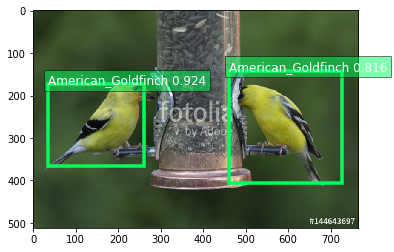

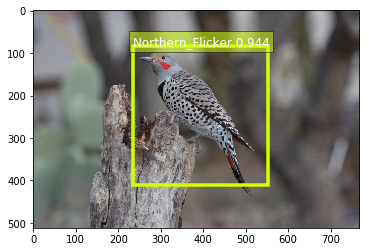

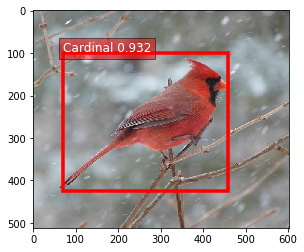

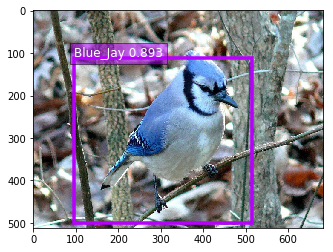

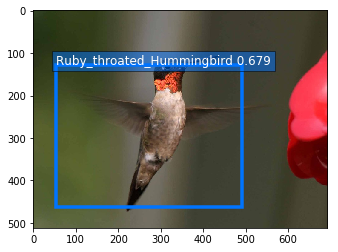

In [28]:
TEST_IMAGES = ['multi-goldfinch-1.jpg','northern-flicker-1.jpg', 
          'northern-cardinal-1.jpg','blue-jay-1.jpg','hummingbird-1.jpg']
CLASSES = ['Cardinal','Northern_Flicker','American_Goldfinch', 'Ruby_throated_Hummingbird','Blue_Jay']
runtime = boto3.client(service_name='runtime.sagemaker')

def test_endpoint(img_file_list) :
    
    for img in img_file_list :

        b = generate_request_payload(img)
        response = runtime.invoke_endpoint(EndpointName=yolo_rt_ep.endpoint,
                                            ContentType='image/jpeg',
                                            Body=b)

        c,s,bb = parse_response_paylod(response)

        trans_X, trans_image = gcv.data.transforms.presets.yolo.transform_test(mx.img.imdecode(b), 512)
        ax = viz.plot_bbox(trans_image, bb, s,c, class_names=CLASSES)
        plt.show()
    
test_endpoint(TEST_IMAGES)   

# Clean up
Here we delete the SageMaker endpoint, as we will no longer be performing any inferences.  This is an important step, as your account is billed for the amount of time an endpoint is running, even when it is idle.

In [29]:
sagemaker.Session().delete_endpoint(yolo_rt_ep.endpoint)